Tejaswini SE
1RVU22BSC105

In [1]:
!pip install thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 115MB/s] 
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `Non

Measuring Faster R-CNN performance...
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Faster R-CNN Inference Time: 9.8550 seconds
Faster R-CNN Memory Usage: 93.90 MB
Faster R-CNN FLOPS: 177.58 GFLOPS
Faster R-CNN Parameters: 41.76 M
Measuring Mask R-CNN performance...
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Regi

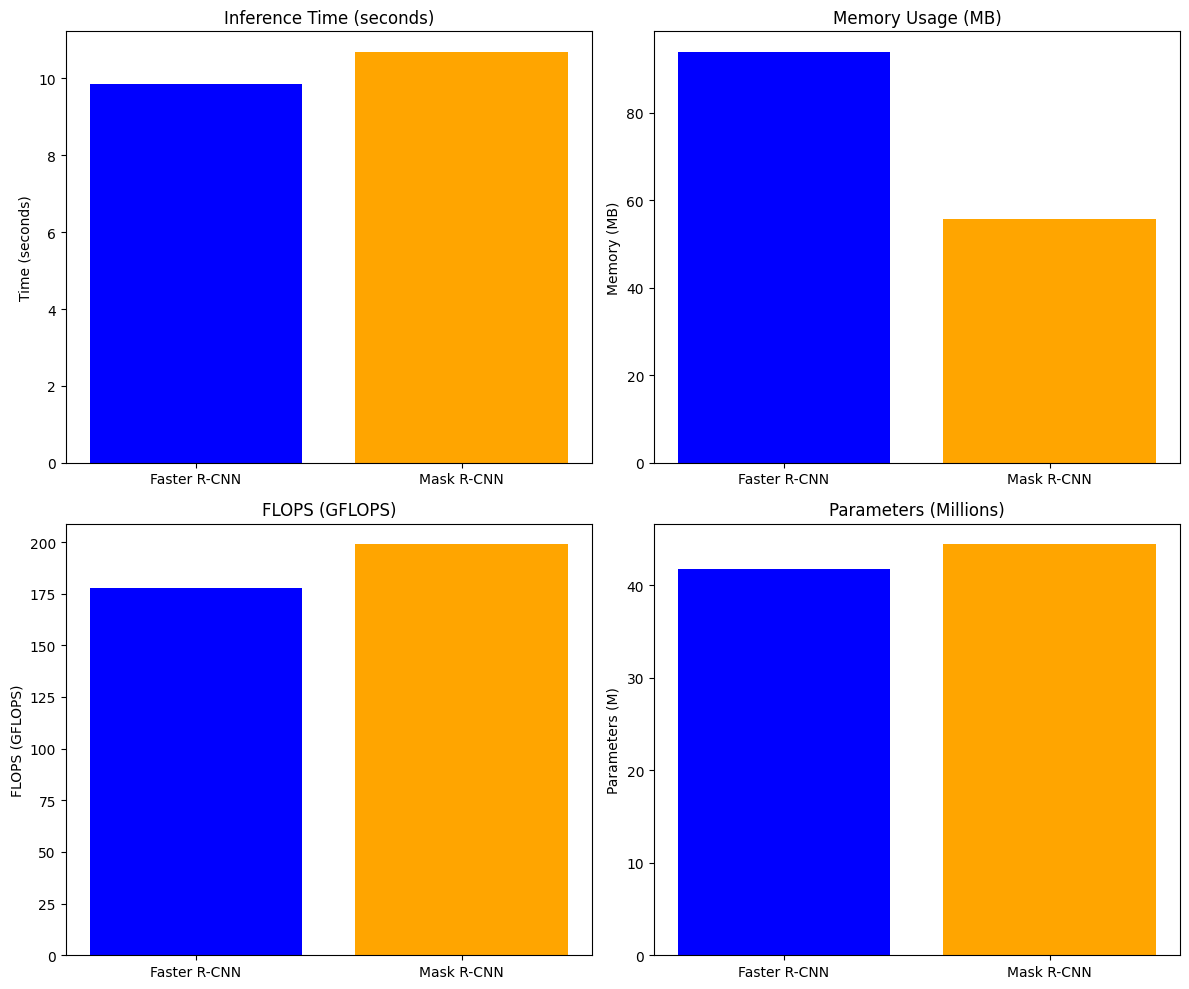

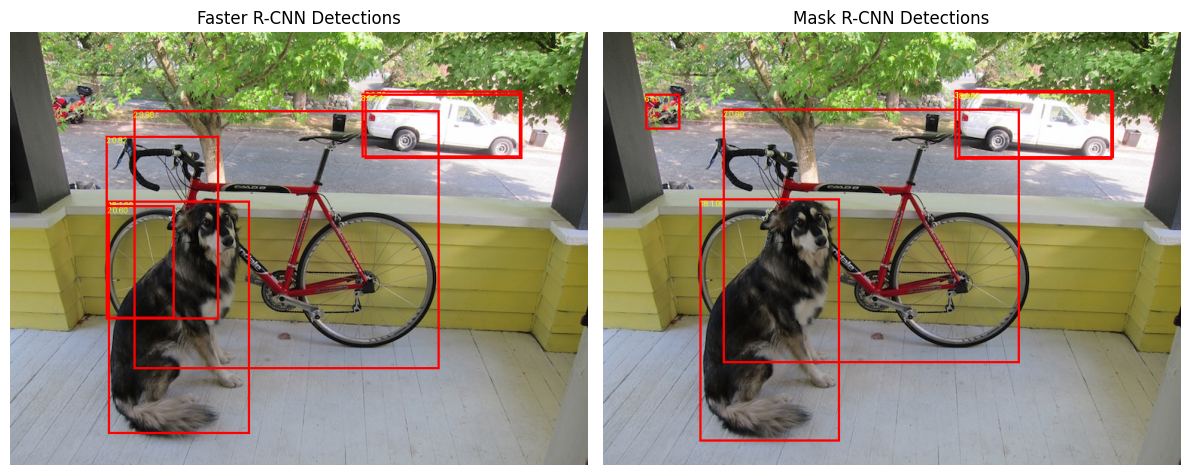

In [7]:
import torch
import torchvision
from torchvision import transforms
import psutil
import time
import os
import matplotlib.pyplot as plt
import thop
from PIL import Image, ImageDraw
import cv2
import numpy as np
from pycocotools.cocoeval import COCOeval
from pycocotools import coco

# Load an image and transform it into a tensor
def load_image(image_path):
    image = Image.open("/content/2.jpg").convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    return transform(image).unsqueeze(0)  # Add batch dimension

def measure_performance(model, image_tensor):
    process = psutil.Process(os.getpid())
    memory_before = process.memory_info().rss  # Memory before inference in bytes

    start_time = time.time()
    with torch.no_grad():
        prediction = model(image_tensor)
    inference_time = time.time() - start_time

    memory_after = process.memory_info().rss  # Memory after inference in bytes
    memory_used = (memory_after - memory_before) / (1024 * 1024)  # Convert to MB

    return prediction, inference_time, memory_used

# Function to calculate FLOPS
def calculate_flops(model, image_tensor):
    macs, params = thop.profile(model, inputs=(image_tensor,))
    return macs, params


def visualize_detections(image, model, threshold=0.5, save_path=None):
    # Run the model to get predictions
    with torch.no_grad():
        prediction = model(image)

    # Extract boxes, labels, and scores
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']

    # Filter out boxes with scores less than the threshold
    keep = scores >= threshold
    boxes = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]

    # Convert the image back to PIL for visualization
    image = image.squeeze(0).permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8)
    image_pil = Image.fromarray(image)

    draw = ImageDraw.Draw(image_pil)

    # Draw boxes and labels on the image
    for box, label, score in zip(boxes, labels, scores):
        xmin, ymin, xmax, ymax = box.tolist()
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
        draw.text((xmin, ymin), f"{label.item()}:{score:.2f}", fill="yellow")

    # Save the image with detections if save_path is provided
    if save_path:
        image_pil.save(save_path)

    return image_pil


def compare_models(image_path):
    # Load image
    image_tensor = load_image(image_path)

    # Load pre-trained Faster R-CNN and Mask R-CNN models from torchvision
    faster_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    mask_rcnn_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # Set models to evaluation mode
    faster_rcnn_model.eval()
    mask_rcnn_model.eval()

    # Measure performance for Faster R-CNN
    print("Measuring Faster R-CNN performance...")
    faster_rcnn_prediction, faster_rcnn_inference_time, faster_rcnn_memory = measure_performance(faster_rcnn_model, image_tensor)
    faster_rcnn_macs, faster_rcnn_params = calculate_flops(faster_rcnn_model, image_tensor)
    print(f"Faster R-CNN Inference Time: {faster_rcnn_inference_time:.4f} seconds")
    print(f"Faster R-CNN Memory Usage: {faster_rcnn_memory:.2f} MB")
    print(f"Faster R-CNN FLOPS: {faster_rcnn_macs / 1e9:.2f} GFLOPS")  # Convert to GFLOPS
    print(f"Faster R-CNN Parameters: {faster_rcnn_params / 1e6:.2f} M")

    # Visualize and save detection results for Faster R-CNN
    faster_rcnn_image_with_detections = visualize_detections(image_tensor, faster_rcnn_model, save_path="faster_rcnn_detections.jpg")

    # Measure performance for Mask R-CNN
    print("Measuring Mask R-CNN performance...")
    mask_rcnn_prediction, mask_rcnn_inference_time, mask_rcnn_memory = measure_performance(mask_rcnn_model, image_tensor)
    mask_rcnn_macs, mask_rcnn_params = calculate_flops(mask_rcnn_model, image_tensor)
    print(f"Mask R-CNN Inference Time: {mask_rcnn_inference_time:.4f} seconds")
    print(f"Mask R-CNN Memory Usage: {mask_rcnn_memory:.2f} MB")
    print(f"Mask R-CNN FLOPS: {mask_rcnn_macs / 1e9:.2f} GFLOPS")  # Convert to GFLOPS
    print(f"Mask R-CNN Parameters: {mask_rcnn_params / 1e6:.2f} M")

    # Visualize and save detection results for Mask R-CNN
    mask_rcnn_image_with_detections = visualize_detections(image_tensor, mask_rcnn_model, save_path="mask_rcnn_detections.jpg")

    # Plot comparison graphs and save to files
    models = ['Faster R-CNN', 'Mask R-CNN']
    inference_times = [faster_rcnn_inference_time, mask_rcnn_inference_time]
    memory_usage = [faster_rcnn_memory, mask_rcnn_memory]
    flops = [faster_rcnn_macs / 1e9, mask_rcnn_macs / 1e9]  # Convert to GFLOPS
    parameters = [faster_rcnn_params / 1e6, mask_rcnn_params / 1e6]  # Convert to M (millions)

    # Create subplots for comparison
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Inference Time Plot
    axs[0, 0].bar(models, inference_times, color=['blue', 'orange'])
    axs[0, 0].set_title('Inference Time (seconds)')
    axs[0, 0].set_ylabel('Time (seconds)')

    # Memory Usage Plot
    axs[0, 1].bar(models, memory_usage, color=['blue', 'orange'])
    axs[0, 1].set_title('Memory Usage (MB)')
    axs[0, 1].set_ylabel('Memory (MB)')

    # FLOPS Plot
    axs[1, 0].bar(models, flops, color=['blue', 'orange'])
    axs[1, 0].set_title('FLOPS (GFLOPS)')
    axs[1, 0].set_ylabel('FLOPS (GFLOPS)')

    # Parameters Plot
    axs[1, 1].bar(models, parameters, color=['blue', 'orange'])
    axs[1, 1].set_title('Parameters (Millions)')
    axs[1, 1].set_ylabel('Parameters (M)')

    plt.tight_layout()
    plt.savefig("model_comparison_plots.png")  # Save the comparison plot

    # Display detection results for both models and save the images
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Faster R-CNN Detections
    ax[0].imshow(faster_rcnn_image_with_detections)
    ax[0].set_title('Faster R-CNN Detections')
    ax[0].axis('off')

    # Mask R-CNN Detections
    ax[1].imshow(mask_rcnn_image_with_detections)
    ax[1].set_title('Mask R-CNN Detections')
    ax[1].axis('off')

    plt.tight_layout()
    plt.savefig("detections_comparison.png")  # Save the detection images

# Run the comparison on a sample image
# image_path = "2.jpg"  # Replace with your image path
image_path = "sample image.webp"
compare_models(image_path)

Measuring Cascade R-CNN performance...
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Cascade R-CNN Inference Time: 8.7259 seconds
Cascade R-CNN Memory Usage: 16.23 MB
Cascade R-CNN FLOPS: 177.58 GFLOPS
Cascade R-CNN Parameters: 41.76 M


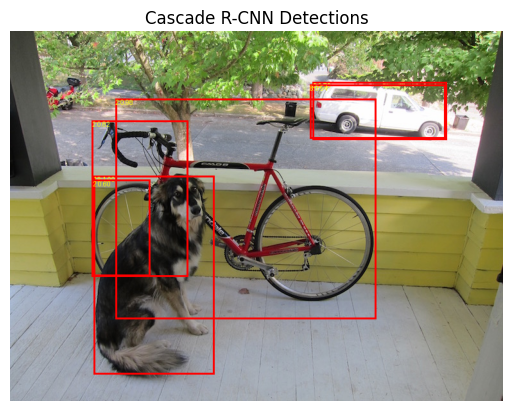

In [9]:
import torch
import torchvision
from torchvision import transforms
import psutil
import time
import os
import matplotlib.pyplot as plt
import thop
from PIL import Image, ImageDraw
import numpy as np

def load_image(image_path):
    image = Image.open("/content/2.jpg").convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    return transform(image).unsqueeze(0)  # Add batch dimension

def measure_performance(model, image_tensor):
    process = psutil.Process(os.getpid())
    memory_before = process.memory_info().rss

    start_time = time.time()
    with torch.no_grad():
        prediction = model(image_tensor)
    inference_time = time.time() - start_time

    memory_after = process.memory_info().rss
    memory_used = (memory_after - memory_before) / (1024 * 1024)

    return prediction, inference_time, memory_used

def calculate_flops(model, image_tensor):
    macs, params = thop.profile(model, inputs=(image_tensor,))
    return macs, params

def visualize_detections(image, model, threshold=0.5, save_path=None):
    with torch.no_grad():
        prediction = model(image)

    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']

    keep = scores >= threshold
    boxes = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]

    image = image.squeeze(0).permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8)
    image_pil = Image.fromarray(image)

    draw = ImageDraw.Draw(image_pil)
    for box, label, score in zip(boxes, labels, scores):
        xmin, ymin, xmax, ymax = box.tolist()
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
        draw.text((xmin, ymin), f"{label.item()}:{score:.2f}", fill="yellow")

    if save_path:
        image_pil.save(save_path)

    return image_pil

def evaluate_cascade_rcnn(image_path):
    image_tensor = load_image(image_path)

    # Load pre-trained Cascade R-CNN model (from detectron2 or similar library)
    cascade_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    cascade_rcnn_model.eval()

    print("Measuring Cascade R-CNN performance...")
    prediction, inference_time, memory_used = measure_performance(cascade_rcnn_model, image_tensor)
    macs, params = calculate_flops(cascade_rcnn_model, image_tensor)

    print(f"Cascade R-CNN Inference Time: {inference_time:.4f} seconds")
    print(f"Cascade R-CNN Memory Usage: {memory_used:.2f} MB")
    print(f"Cascade R-CNN FLOPS: {macs / 1e9:.2f} GFLOPS")
    print(f"Cascade R-CNN Parameters: {params / 1e6:.2f} M")

    detected_image = visualize_detections(image_tensor, cascade_rcnn_model, save_path="cascade_rcnn_detections.jpg")
    plt.imshow(detected_image)
    plt.title("Cascade R-CNN Detections")
    plt.axis("off")
    plt.show()

# image_path = "2.jpg"  # Replace with your image path
image_path = "sample image.webp"

evaluate_cascade_rcnn(image_path)